In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer


df = pd.read_csv('taxi_trip_pricing.csv')

In [110]:
df

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
...,...,...,...,...,...,...,...,...,...,...,...
995,5.49,Afternoon,Weekend,4.0,Medium,Clear,2.39,0.62,0.49,58.39,34.4049
996,45.95,Night,Weekday,4.0,Medium,Clear,3.12,0.61,NaN,61.96,62.1295
997,7.70,Morning,Weekday,3.0,Low,Rain,2.08,1.78,NaN,54.18,33.1236
998,47.56,Morning,Weekday,1.0,Low,Clear,2.67,0.82,0.17,114.94,61.2090


In [111]:
print(df.describe())

       Trip_Distance_km  Passenger_Count   Base_Fare  Per_Km_Rate  \
count        950.000000       950.000000  950.000000   950.000000   
mean          27.070547         2.476842    3.502989     1.233316   
std           19.905300         1.102249    0.870162     0.429816   
min            1.230000         1.000000    2.010000     0.500000   
25%           12.632500         1.250000    2.730000     0.860000   
50%           25.830000         2.000000    3.520000     1.220000   
75%           38.405000         3.000000    4.260000     1.610000   
max          146.067047         4.000000    5.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  
count       950.000000             950.000000  951.000000  
mean          0.292916              62.118116   56.874773  
std           0.115592              32.154406   40.469791  
min           0.100000               5.010000    6.126900  
25%           0.190000              35.882500   33.742650  
50%           0.29

In [112]:
print(df.isnull().sum())

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64


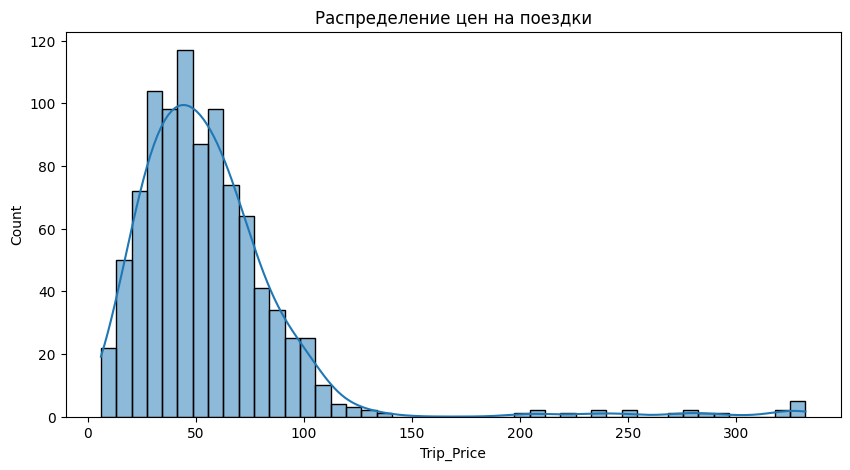

In [113]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Trip_Price'], kde=True)
plt.title('Распределение цен на поездки')
plt.show()

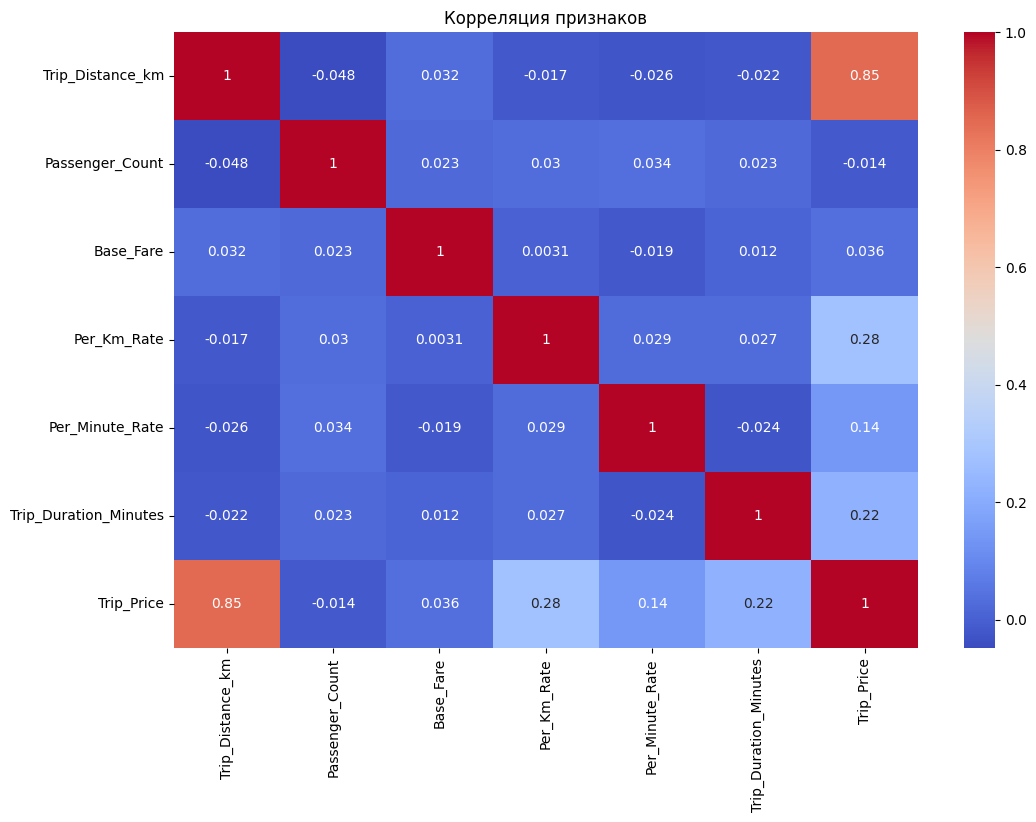

In [114]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

In [115]:
df = df.dropna(subset=['Trip_Price'])
X = df.drop('Trip_Price', axis=1)
y = df['Trip_Price']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
imputer_num = SimpleImputer(strategy='median')

X_train_num = imputer_num.fit_transform(X_train[num_cols])
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)

In [118]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train_cat)

In [119]:
X_train_final = np.hstack((X_train_num_scaled, X_train_cat_encoded))

In [120]:
models = {
    'Linear Regression': LinearRegression(), 
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [121]:
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [124]:
print("Сравнение MAE:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_final, y_train, cv=kf, scoring='neg_mean_absolute_error')    
    mae_mean = -cv_scores.mean()
    results[name] = mae_mean
    print(f"{name}: Средняя MAE = {mae_mean:.4f}")
    
best_name = min(results, key=results.get)
print(f"Лучшая модель: {best_name}")

Сравнение MAE:
Linear Regression: Средняя MAE = 9.4726
Ridge: Средняя MAE = 9.4557
Random Forest: Средняя MAE = 6.0856
Gradient Boosting: Средняя MAE = 5.2584
XGBoost: Средняя MAE = 6.1387
Лучшая модель: Gradient Boosting


In [125]:
X_test_num_scaled = scaler.transform(imputer_num.transform(X_test[num_cols]))
X_test_cat_encoded = encoder.transform(imputer_cat.transform(X_test[cat_cols]))
X_test_final = np.hstack((X_test_num_scaled, X_test_cat_encoded))

final_model = models[best_name]
final_model.fit(X_train_final, y_train)
y_pred_final = final_model.predict(X_test_final)
final_mae = mean_absolute_error(y_test, y_pred_final)


print(f"Финальная MAE НА ТЕСТЕ {best_name}: {final_mae:.4f}")


Финальная MAE НА ТЕСТЕ Gradient Boosting: 5.3413
